### Relatório Dataming - Avito Demand Prediction Challenge

#### Time:
- Filipe Koop
- Lucas Pérez
- Raphael Coelho

### 1- Introdução

Avito é um website russo de classificados, muito parecido com alguns que temos aqui no Brasil, como por exemplo, o Mercado Livre. Avito.ru é o site de classificados mais popular da Russia e o terceiro mais popular do mundo. Em média, os usuários do site, postam mais de 500,000 anúncios diariamente e há em torno de 30 milhões de anúncios ativos.

Apesar de haver um grande número de vendedores e compradores, a quantidade massiva de anúncios faz alguns produtos serem pouco visiveis ao publico, enquanto outros acabam tendo uma demanda muito maior que a oferta. Este problema gerou uma competição na plataforma kaggle, com o objetivo de disponibilizar os dados do site de classificados Avito para que diversos pesquisadores e estudiosos pudessem tentar achar uma solução para o problema em questão ou alternativas que melhor explicassem o que os dados dizem.

Com este intuito, foi realizado este trabalho buscando extrair informações sobre os dados que auxiliassem a entender padrões e possíveis comportamentos de acordo com as variáveis disponíveis.

### 2- Os Dados

Ao todo, temos um enorme volume de dados disponível na plataforma kaggle. São por volta de 60 gigabytes de dados dividos em várias pastas, todos eles em russo. Entretanto, para este trabalho foi utilizado um pouco mais de 1 gigabyte dentre os dados disponíveis. 

Os dados estavam divididos primordialmente entre dados de treino e dados de teste. Onde tinhamos por volta de mais de 1 milhao e meio de linhas na tabela de treino e um pouco mais de 500 mil linhas na tabela de teste com as seguintes colunas:

- item_id: Id do  anúncio
- user_id: ID do usuário
- region: Região do anúncio
- city: Cidade do anúncio
- category_name: Categoria do anúncio classificado pelo modelo de anúncios da Avito
- parent_category_name: Categoria de alto nível dos anúncios classificado pelo modelo de anúncios da Avito
- param 1,2,3: Parametros opcionais para o modelo de anúncios da Avito
- title: Título do anúncio
- description: Descrição do anúncio
- price: Preço do anúncio
- item_seq_number: Número sequencial do anúncio por usuários
- activation_date: Data da ativação do anúncio no site
- user_type: Tipo de usuário
- image: Código id da imagem do anúncio
- image_top_1: Código de classificação da Avito para as imagens
- deal_probability: A variável alvo. É a probabilidade do anúncio realmente vender algo.

Foi feita a fusão das duas tabelas gerando em um grande repositório onde foram removidas as duas colunas de imagens e a item_seq_number e foram, acrescentados duas novas colunas:

- month: Mês da ativação do anúncio
- source: Marcação da base de origem da linha em questão.

Desse modo, foi obtido uma base de dados com mais de 2 milhões de linhas de dados divididos em 17 colunas



In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib  inline
dir = 'C:\\Users\\rapha\\PythonP\\'

def get_dataset(source):
    print(source)
    df = pd.read_csv(dir + source + '.csv', encoding='utf-8', low_memory=False, parse_dates=["activation_date"])
    display(df.shape)
    df['month'] = (df['activation_date'].apply(lambda x: x.month)).astype(int)
    df['source'] = str(source)
    df.drop(['image', 'image_top_1', 'item_seq_number'], axis=1, inplace=True)
    return df

In [4]:
train = get_dataset('train')
test = get_dataset('test')

train


(1503424, 18)

test


(508438, 17)

In [12]:
df = train.append(test, ignore_index=True)
display(df.head())
display(df.shape)

,activation_date,category_name,city,deal_probability,description,item_id,month,param_1,param_2,param_3,parent_category_name,price,region,source,title,user_id,user_type
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,0.12789,"Кокон для сна малыша,пользовались меньше месяц...",b912c3c6a6ad,3,Постельные принадлежности,NaN,NaN,Личные вещи,400.0,Свердловская область,train,Кокоби(кокон для сна),e00f8ff2eaf9,Private
1,2017-03-26,Мебель и интерьер,Самара,0.00000,"Стойка для одежды, под вешалки. С бутика.",2dac0150717d,3,Другое,NaN,NaN,Для дома и дачи,3000.0,Самарская область,train,Стойка для Одежды,39aeb48f0017,Private
2,2017-03-20,Аудио и видео,Ростов-на-Дону,0.43177,"В хорошем состоянии, домашний кинотеатр с blu ...",ba83aefab5dc,3,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0,Ростовская область,train,Philips bluray,91e2f88dd6e3,Private
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,0.80323,Продам кресло от0-25кг,02996f1dd2ea,3,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0,Татарстан,train,Автокресло,bf5cccea572d,Company
4,2017-03-16,Автомобили,Волгоград,0.20797,Все вопросы по телефону.,7c90be56d2ab,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0,Волгоградская область,train,"ВАЗ 2110, 2003",ef50846afc0b,Private


(2011862, 17)

### 3- Abordagem

Para enteder os dados, adotou-se primeiramente uma abordagem estatística,com as bibliotecas numpy, pandas e seaborn, utilizando-se de várias visualizações manipulando os dados afim de obter algum conhecimento sobre as suas variaveis e até mesmo as suas bases de dados de origem, (treino e teste). Para isto, também foi utilizado uma pequena base com dados adicionais com os periodos de ativação dos anúncios, tanto de teste quanto de treino.

Por conseguinte, foi utilizado a geração do "bag os words", uma vez que temos várias colunas com textos, e que pode-se extrair informações relevantes. O modelo "bag of words" é uma representação simplificada usada em processamento de linguagem natural. Neste modelo, um texto é representado como a "sacola"(conjunto) de palavras que serão estudadas para identificar padrões ou algo similar.

### 3.1- Análises Estatísticas

### 3.1.1- Tipos de Usuários

Primeiramente, observemos a probabilidade de venda de acordo com o tipo de cliente. Temos três tipos de clientes:
- Privates
- Companys
- Shop
Se olharmos as médias dessas probabilidades por tipo de usuário, o que pode ser mostrado?

Observamos então, que a média mais alta se encontra em 0.4 para os usuários privados. Entretanto, na mesma linha podemos observar que a mesma categoria de anúncio detem também as médias mais altas para os outros tipos de usuários.

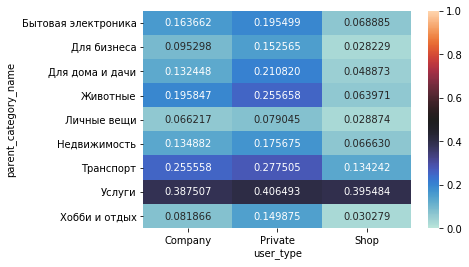

In [4]:
mean_probability = train.groupby(['parent_category_name','user_type'])['deal_probability'].mean().unstack()
sns.heatmap(mean_probability, vmin=0, vmax=1, center=0.5, annot=True, fmt="f")

Pensemos agora sobre a quantidade de anúncios de cada categoria para os três tipos de usuários. Logo percebemos que grande parte dos anúncios são destinados ao público private. Em todas as categorias, é possivel ver que a maior parte de anúncios está destinada para estes usuários e a quinta categoria tem a maior quantidade.

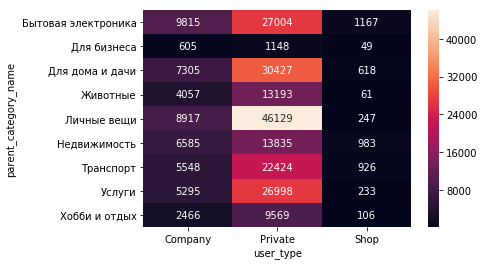

In [9]:
mean_probability2 = train[train['deal_probability'] > 0.3].groupby(['parent_category_name','user_type'])['deal_probability'].count().unstack()
sns.heatmap(mean_probability2, annot=True, fmt="d")

Vimos que os maiores valores das visualizações anteriores dizem respeito aos usuários do tipo private. 
O que poderia nos dizer que eles representam a maioria da base. Pensameos então em agrupar o tipo de usuário pela média
da prbabiliade.

Vemos então, com o gráfico abaixo que é notório a quantidade de usuário do tipo private, seguido pelos usuários do tipo
company, e por fim os de tipo shop. Isso corrobora as visualizações anteriores onde se vê um padrão de quantidade em cima de cada tipo de usuário. Entretanto, se formos observar, a diferença entre usuários do tipo private e company, não é tão grande. Todavia, há uma grande discrepância na quantidade de anúncios ofertados a estes dois usuários. em algumas categorias chegamos a ter quase cinco vezes mais anúncios para usuários do tipo private.

Possivelmente seria uma estrategia interessante dos anunciantes que tem pouca demanda, voltarem as suas atenções aos usuários do tipo company, e os que tem uma demanda muito maior que a oferta, focar em um tipo específico de usuário.


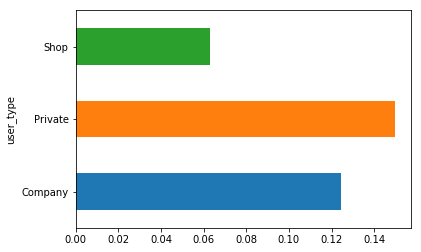

In [11]:
train.groupby('user_type')['deal_probability'].mean().plot(kind='barh')

É interessante verificar também que há um número expressiveo de anúncios nas três categorias que tem as probabilidades de venda de 0 à 0.4. Para os usuários do tipo shop, é nitido ver que mais de 50% dos anúncios estão nesse intervalo. Isso nos mostra que os anúncios não estão suprindo as expectativas de compra dos usuários. Mesmo nos usuários de tipo company e private, onde há uma grande número de anúncios na faixa de 0.8, ainda há um número expressivo nas faixas mais baixas. Em company, há mais anúncios em 0.1 de probabilidade do que em 0.8.

Como nós costatamos nas visualizações anteriores, company, é um tipo de usuário com um núemro expressivo na base de dados da Avito. Logo, para um maior sucesso e chande de compra dos produtos nos anúncios, seria interessante verificar se aquele produto, e a forma como ele está sendo anunciado, está de acordo com o publico que ele está sendo destinado.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014C1BF9D518>,
      dtype=object)

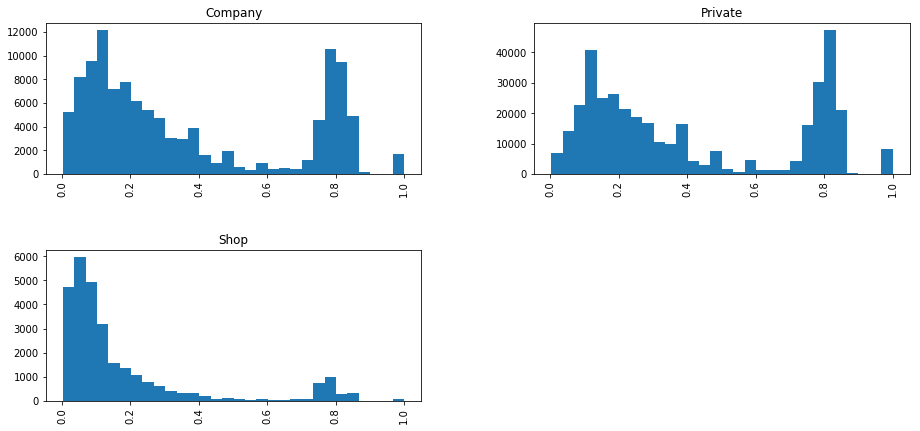

In [7]:
train[train.deal_probability>0].deal_probability.hist(by=(train.user_type),bins=30, figsize=(15,7))

### 3.1.2- Regiões

Observamos agora as regiões. Será que há alguma região que se sobressai sobre as outras? Se formos agrupar as regiões usando a média da probabilidade percebemos que há uma certa uniformidade entre as mesmas.

Por outro lado, se formor analisar utilizando contagem, percebemos uma nitida heterogenidade. Temos a região de Краснодарский край (Krai de Krasnodar) que se destaca das outras passando dos 140.000 anúncios, enquanto que as outras regiões com os maiores registros passam um pouco de 80.000.

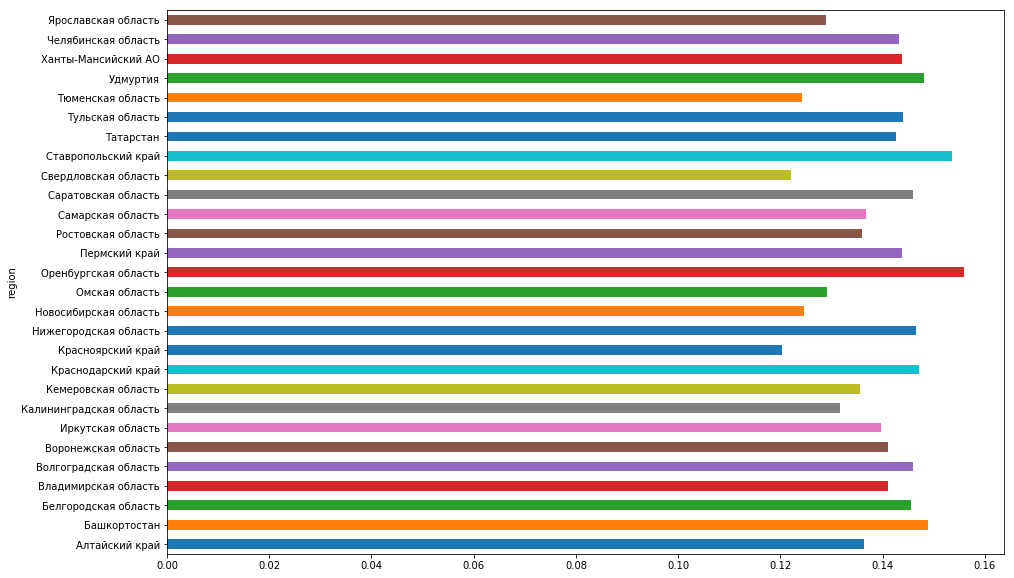

In [9]:
train.groupby('region')['deal_probability'].mean().plot(kind='barh', figsize=(15,10))

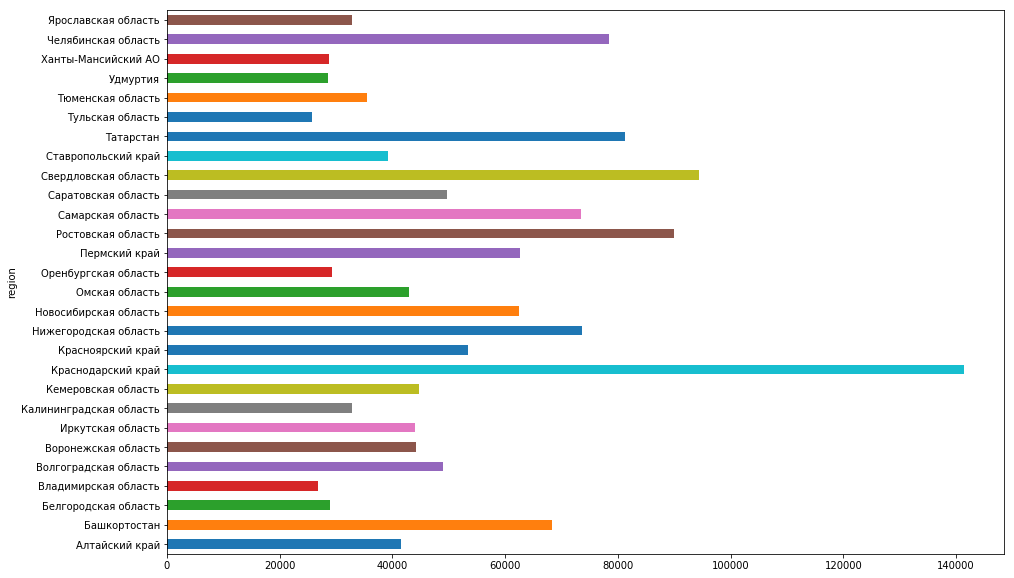

In [10]:
train.groupby('region')['deal_probability'].count().plot(kind='barh', figsize=(15,10))

### 3.1.3- Comparação entre as Bases

Como dito anteriormente, temos como origem duas bases de dados: treino e teste. Comparando ambas, podemos encontrar alguma informação relevante?

Primeiro olhamos a que mês se refere cada base, e observamos que a base de treino corresponde a mais de 75% da base total. Pensando nisso, imagina-se que o número de anúncios por região seja bem mais expressivo no mês 3 correspondente a base de treino. Todavia, vimos que ambas as bases mantem-se bem proximas neste quesito e em algumas regiões, há mais anúncios no mês 4(teste).

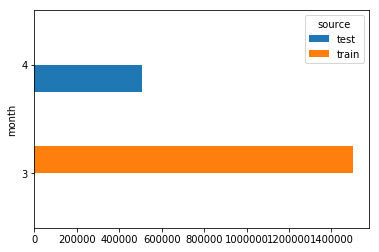

In [13]:
mon = df.groupby(['month','source'])['item_id'].count().unstack().fillna(0)
mon.plot(kind='barh')

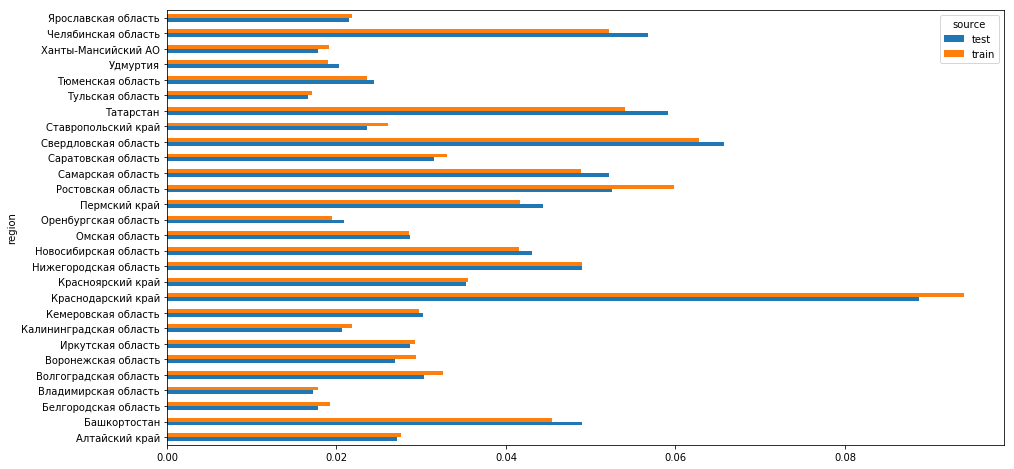

In [15]:
reg = df.groupby(['region','source'])['item_id'].count().unstack()
reg['test'] = reg['test'] / test.shape[0]
reg['train'] = reg['train'] / train.shape[0]
reg.plot(kind='barh',  figsize=(15,8))

Analisando os preços de ambas as bases, percebemos que as duas seguem a mesma distribuição, apenas tendo variação na grandeza dos anúncios ofertados. tanto na base de treino como de teste, a grande maioria dos anúncios estava com preços até 3000, com picos de 500 em 500.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001538EF7DE10>,
      dtype=object)

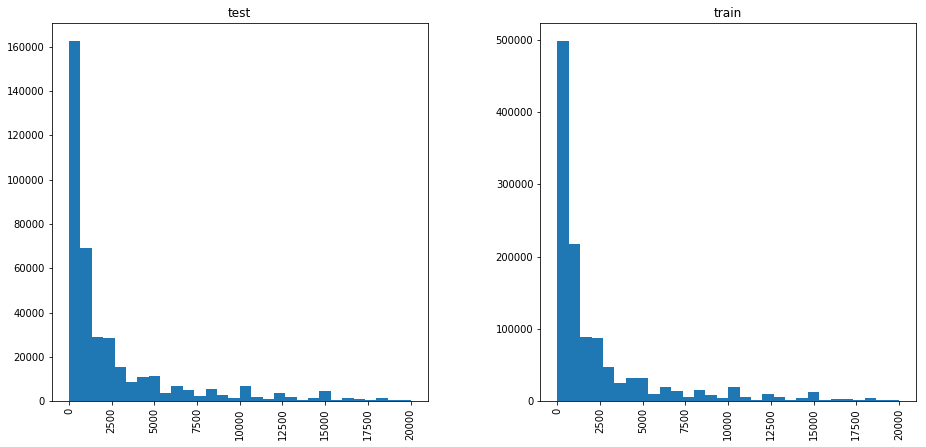

In [16]:
df.price[df.price<20000].hist(by=(df.source), bins=30, figsize=(15,7))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000014C1E938550>,
      dtype=object)

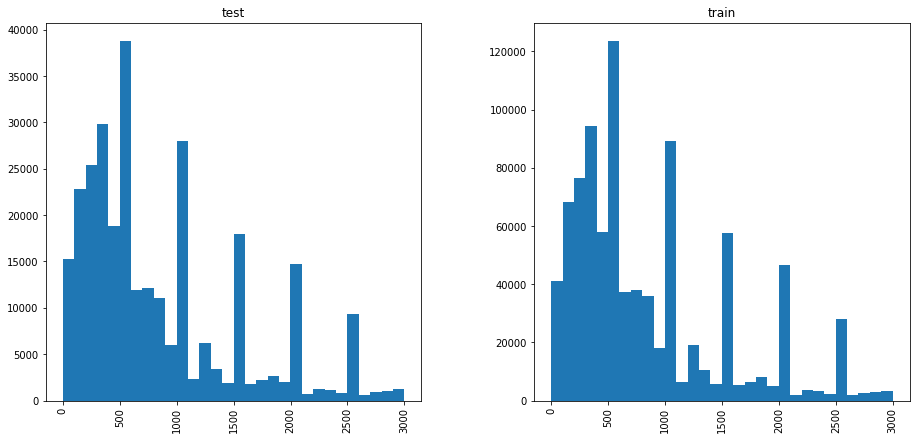

In [16]:
df.price[df.price<3000].hist(by=(df.source), bins=30, figsize=(15,7))

Por fim, analisamos a distribuição dos tipos de usuarios, e é nitido e fácil de perceber que em ambas as bases, os usuários seguem uma distribuição semelhante.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015392196E80>,
      dtype=object)

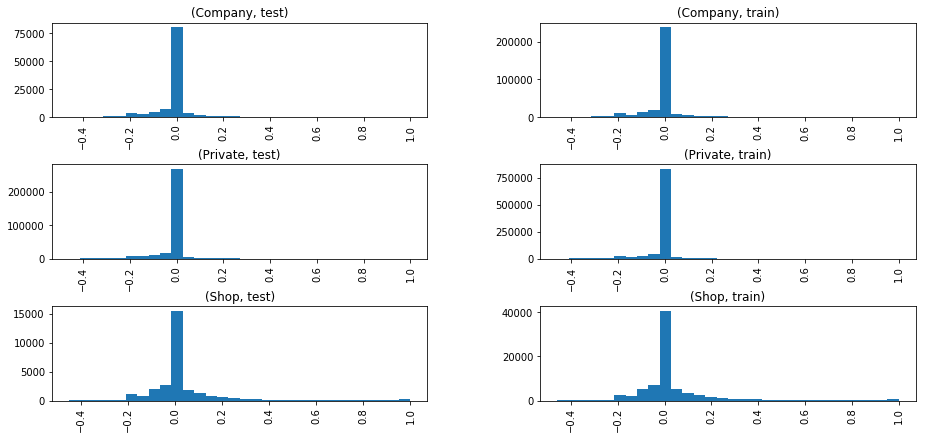

In [18]:
df2.price_normal.hist(by=([df2.user_type, df2.source]),bins=30, figsize=(15,7))

### 3.1.4 Análise do Tempo Ativo dos Anúncios

Para complementar as análises temporais, foi utilizado duas outrs bases de dadoss que correspondem aos periodos que os anúncios ficaram ativos no site. Com essas bases podemos averiguar quanto tempo cada anúncio ficou ativo fazendo uma simples subtração pelas datas. Assim criou-se a coluna time_diff que nos da ess valor.

In [18]:
periods_train = pd.read_csv(dir + 'periods_train.csv', encoding='utf-8', low_memory=False, 
                            parse_dates=['activation_date','date_from','date_to'])
periods_test = pd.read_csv(dir + 'periods_test.csv', encoding='utf-8', low_memory=False, 
                           parse_dates=['activation_date','date_from','date_to'])
df_period = periods_train.append(periods_test, ignore_index=True)
display(df_period.shape)
df_period.head()

(30412334, 4)

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


In [19]:
df_period['time_diff'] = ((df_period.date_to - df_period.date_from) / np.timedelta64(1, 'D')).astype(int)
df_period.head()

,item_id,activation_date,date_from,date_to,time_diff
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13


Mostramos então uma pequena tabela com os 20 primeiros anúncios, e seus respectivos tempos ativos, de início e fim.

Como seria então a distribuição desse tempo? Pelo histograma, é possível perceber picos de 5 em 5 dias, mais ou menos. Ou seja, grande parte dos anúncios ficam disponíveis por volta de 7.5, 12.5 e 17.5 dias. Isso pode nos mostrar uma certa tendência do consumidor que leva um certo tempo até comprar algo que foi anúnciado.

In [21]:
p_g = df_period.groupby('item_id')['time_diff'].sum()
p_min = df_period.groupby('item_id')['date_from'].min()
p_max = df_period.groupby('item_id')['date_to'].max()

p_c = df_period.groupby('item_id')['item_id'].count()

per = pd.concat([p_g,p_c,p_min,p_max], axis=1)

per = per.rename({'item_id': 'per_count'}, axis='columns')
per.reset_index(inplace=True)
per.head(20)

,item_id,time_diff,per_count,date_from,date_to
0,00000077ff21,13,1,2017-03-15,2017-03-28
1,000002c54018,6,1,2017-04-12,2017-04-18
2,000005570503,1,1,2017-04-12,2017-04-13
3,0000060018e6,6,1,2017-04-12,2017-04-18
4,000006497719,19,2,2017-03-15,2017-04-18
5,000006f5c0fd,11,3,2017-03-15,2017-04-18
6,0000079b5cc9,14,2,2017-03-20,2017-04-18
7,000009bdb078,13,1,2017-03-15,2017-03-28
8,00000ae3f45d,16,3,2017-03-15,2017-04-18
9,00000b33142e,19,2,2017-03-15,2017-04-18


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014C6A99A198>]],
      dtype=object)

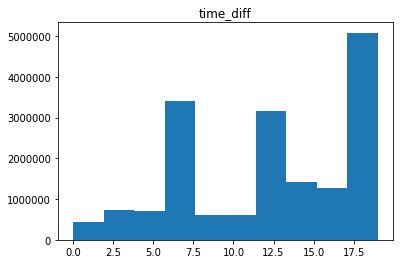

In [42]:
per.hist('time_diff',grid=False)